In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


features = ['date','cheveux','age','exp','salaire','sexe','diplome','specialite','note','dispo','embauche']
dataset = pd.read_csv('data_v1.0.csv', usecols= features, )

In [ ]:
# fix quantitative variables
dataset['age'] = dataset['age'].apply(lambda x: np.nan if x<0 else x )
dataset['exp'] = dataset['exp'].apply(lambda x: np.nan if x<0 else x )
dataset.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [ ]:
neg, pos = np.bincount(dataset['embauche'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 20000
    Positive: 2292 (11.46% of total)



In [ ]:
# fix missing data using imputation with most_frequent strategy
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = SimpleImputer(strategy="most_frequent")
data_imputed = imp.fit_transform(dataset)
data_imputed = pd.DataFrame(data_imputed, columns=features)

In [ ]:
# Enocoding categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_imputed['dispo'] = le.fit_transform(data_imputed['dispo'].astype(str))
data_imputed['cheveux'] = le.fit_transform(data_imputed['cheveux'].astype(str))
data_imputed['sexe'] = le.fit_transform(data_imputed['sexe'].astype(str))
data_imputed['specialite'] = le.fit_transform(data_imputed['specialite'].astype(str))
# data_imputed['age'] = le.fit_transform(data_imputed['age'].astype(str))
data_imputed['diplome'] = le.fit_transform(data_imputed['diplome'].astype(str))

In [ ]:
data_imputed.pop('date')

0        2012-06-02
1        2011-04-21
2        2012-09-07
3        2011-07-01
4        2012-08-07
            ...    
19995    2012-03-10
19996    2010-09-19
19997    2010-09-02
19998    2011-12-06
19999    2010-11-29
Name: date, Length: 20000, dtype: object

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(data_imputed, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('embauche'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('embauche'))
test_labels = np.array(test_df.pop('embauche'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

'''
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)
'''

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (12800,)
Validation labels shape: (3200,)
Test labels shape: (4000,)
Training features shape: (12800, 9)
Validation features shape: (3200, 9)
Test features shape: (4000, 9)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


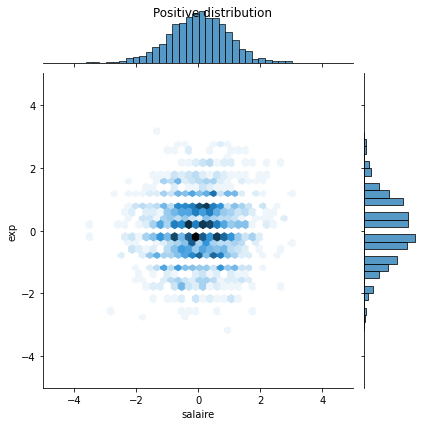

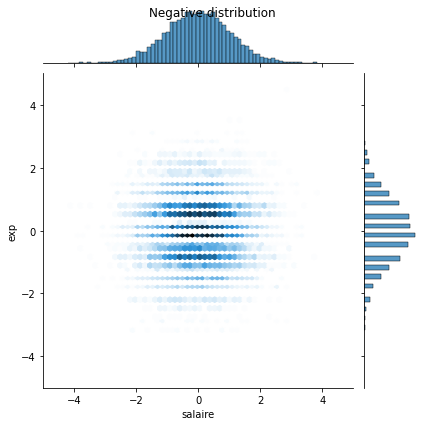

In [ ]:
# check distribution 
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['salaire'], pos_df['exp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['salaire'], neg_df['exp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
EPOCHS = 50
BATCH_SIZE = 8

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(9,)),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation=tf.nn.relu),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  # model.fit(np.array(train_features.astype('float32')), np.array(train_labels.astype('float32')), epochs=EPOCHS,
  #           validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))), callbacks=early_stopping, batch_size=BATCH_SIZE)

  return model

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(train_features[:10])

array([[0.6643246 ],
       [0.64533156],
       [0.61284244],
       [0.6498238 ],
       [0.5895577 ],
       [0.66477096],
       [0.6425071 ],
       [0.62078243],
       [0.6248206 ],
       [0.57634264]], dtype=float32)

In [ ]:
results = model.evaluate(np.array(train_features.astype('float32')), np.array(train_labels.astype('float32')), batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0167


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.04459172])

In [ ]:
pos/total

0.1146

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.15907612],
       [0.19846877],
       [0.13247915],
       [0.15157388],
       [0.13788149],
       [0.12198129],
       [0.12862761],
       [0.16822745],
       [0.1074031 ],
       [0.1412733 ]], dtype=float32)

In [ ]:
results = model.evaluate(np.array(train_features.astype('float32')), np.array(train_labels.astype('float32')), batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3576


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features.astype('float32'),
    train_labels.astype('float32'),
    batch_size=4,
    epochs=20,
    validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features.astype('float32'),
    train_labels.astype('float32'),
    batch_size=4,
    epochs=25,
    validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))), 
    verbose=0)

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

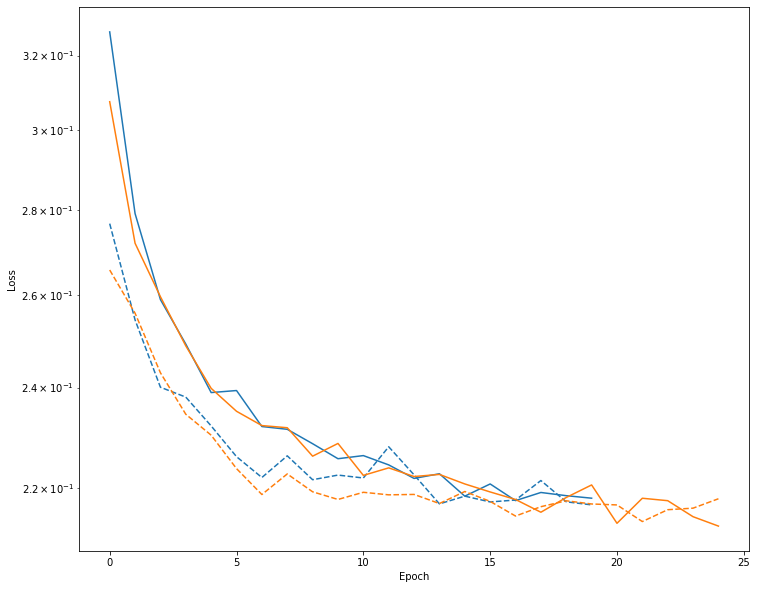

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features.astype('float32'),
    train_labels.astype('float32'),
    batch_size=2,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))))

Epoch 1/30
6400/6400 [==============================] - 67s 10ms/step - loss: 0.3126 - tp: 194.2984 - fp: 51.3617 - tn: 9173.5994 - fn: 982.7402 - accuracy: 0.9015 - precision: 0.7996 - recall: 0.1760 - auc: 0.8089 - prc: 0.4779 - val_loss: 0.2594 - val_tp: 115.0000 - val_fp: 37.0000 - val_tn: 2789.0000 - val_fn: 259.0000 - val_accuracy: 0.9075 - val_precision: 0.7566 - val_recall: 0.3075 - val_auc: 0.8487 - val_prc: 0.5637
Epoch 2/30
6400/6400 [==============================] - 63s 10ms/step - loss: 0.2632 - tp: 181.2062 - fp: 69.0194 - tn: 5608.6397 - fn: 543.1344 - accuracy: 0.9051 - precision: 0.7169 - recall: 0.2571 - auc: 0.8331 - prc: 0.5051 - val_loss: 0.2449 - val_tp: 124.0000 - val_fp: 26.0000 - val_tn: 2800.0000 - val_fn: 250.0000 - val_accuracy: 0.9137 - val_precision: 0.8267 - val_recall: 0.3316 - val_auc: 0.8638 - val_prc: 0.6131
Epoch 3/30
6400/6400 [==============================] - 64s 10ms/step - loss: 0.2460 - tp: 193.9397 - fp: 64.3268 - tn: 5630.4827 - fn: 513.2504

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

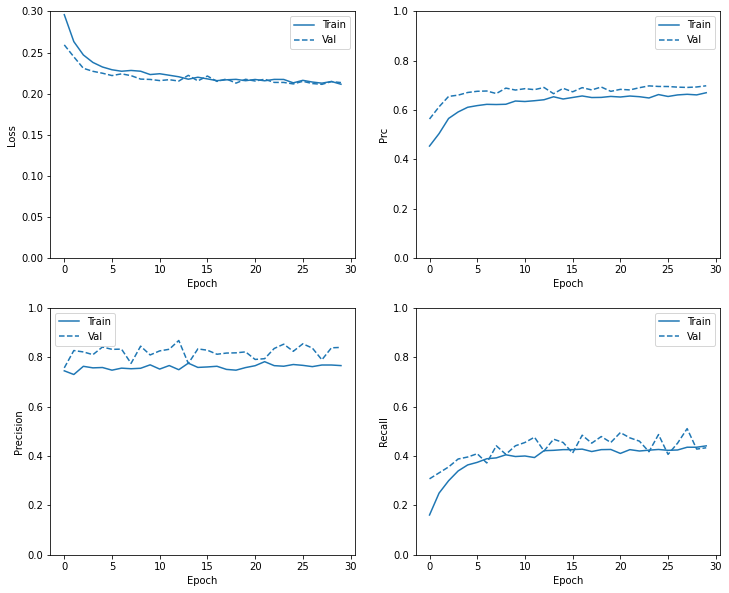

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(np.array(train_features.astype('float32')), batch_size=4)
test_predictions_baseline = model.predict(np.array(test_features.astype('float32')), batch_size=4)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.2331354171037674
tp :  177.0
fp :  39.0
tn :  3481.0
fn :  303.0
accuracy :  0.9144999980926514
precision :  0.8194444179534912
recall :  0.3687500059604645
auc :  0.8809101581573486
prc :  0.6600158214569092

Legitimate Transactions Detected (True Negatives):  3481
Legitimate Transactions Incorrectly Detected (False Positives):  39
Fraudulent Transactions Missed (False Negatives):  303
Fraudulent Transactions Detected (True Positives):  177
Total Fraudulent Transactions:  480


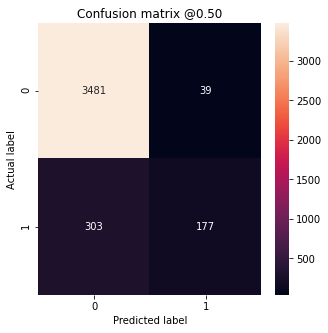

In [ ]:
baseline_results = model.evaluate(np.array(test_features.astype('float32')), np.array(test_labels.astype('float32')),
                                  batch_size=4, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(np.array(test_labels.astype('float32')), test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,40])
  plt.ylim([100,10.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

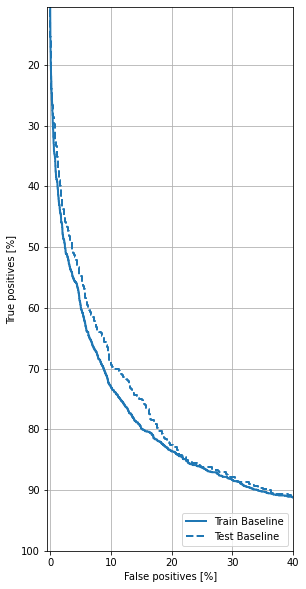

In [ ]:
plot_roc("Train Baseline", np.array(train_labels.astype('float32')), train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", np.array(test_labels.astype('float32')), test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

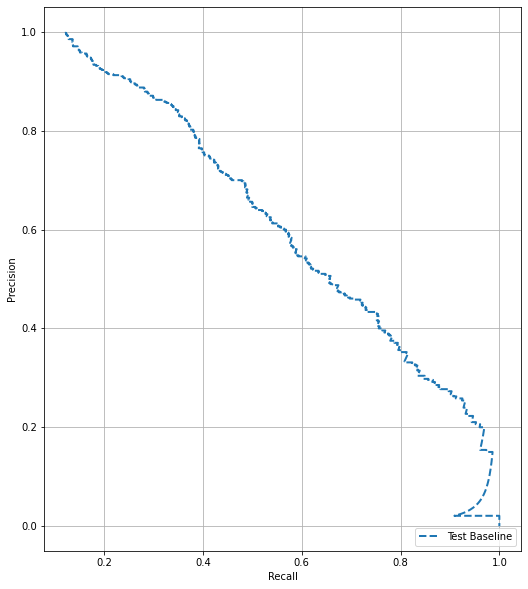

In [ ]:
# plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels.astype('float32'), test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')